In [1]:
from __future__ import print_function
import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K
import numpy as np

batch_size = 128
num_classes = 10
epochs = 1

# input image dimensions
img_rows, img_cols = 28, 28

# the data, split between train and test sets
(x_trainX, y_trainX), (x_testX, y_testX) = mnist.load_data()

Using TensorFlow backend.


11493376/11490434 [==============================] - 1s 0us/step


I want to simply problem will not use 10 digits, with filter set and only use them. For this sample I will only use 0 and 1


In [0]:
def filter_arr(arr,arr2,filter_vals):
  mask = np.isin(arr, filter_vals)
  indexes = np.where(mask)
  print(len(indexes))
  return arr[indexes],arr2[indexes]

In [0]:
y_train, x_train = filter_arr(y_trainX, x_trainX,[0,1])
y_test, x_test = filter_arr(y_testX, x_testX,[0,1])
x_validate = x_testX.copy()
y_validate = y_testX.copy()

1
1


I will define multiple versions for different optimizers.

In [0]:
class TestSession():
  def __init__(self, learning_rate, name,optimizer):
    self.learning_rate = learning_rate
    self.name = name
    self.optimizer = optimizer

  def display(self):
    return  self.name +" : "+ str(self.learning_rate)

test_optimizers = []
learning_rates = [0.0001,0.001,0.01,0.1]
for learning_rate in learning_rates:
  test_optimizers.append(TestSession(learning_rate,"Adam ",keras.optimizers.Adam(lr=learning_rate, beta_1=0.9, beta_2=0.999, amsgrad=False)) )
  test_optimizers.append(TestSession(learning_rate,"SGD (Nesterov=false) ",keras.optimizers.SGD(lr=learning_rate, momentum=0.01, nesterov=False)))
  test_optimizers.append(TestSession(learning_rate,"SGD (Nesterov=true)  ",keras.optimizers.SGD(lr=learning_rate, momentum=0.01, nesterov=True)))
  test_optimizers.append(TestSession(learning_rate,"Adagrad  ",keras.optimizers.Adagrad(lr=learning_rate)))
  test_optimizers.append(TestSession(learning_rate,"Adadelta  ",keras.optimizers.Adadelta(lr=learning_rate, rho=0.95)))
  test_optimizers.append(TestSession(learning_rate,"RMSprop  ",keras.optimizers.RMSprop(lr=learning_rate, rho=0.95)))
  


for optimizer in test_optimizers:
  print( optimizer.display())

Adam  : 0.0001
SGD (Nesterov=false)  : 0.0001
SGD (Nesterov=true)   : 0.0001
Adagrad   : 0.0001
Adadelta   : 0.0001
RMSprop   : 0.0001
Adam  : 0.001
SGD (Nesterov=false)  : 0.001
SGD (Nesterov=true)   : 0.001
Adagrad   : 0.001
Adadelta   : 0.001
RMSprop   : 0.001
Adam  : 0.01
SGD (Nesterov=false)  : 0.01
SGD (Nesterov=true)   : 0.01
Adagrad   : 0.01
Adadelta   : 0.01
RMSprop   : 0.01
Adam  : 0.1
SGD (Nesterov=false)  : 0.1
SGD (Nesterov=true)   : 0.1
Adagrad   : 0.1
Adadelta   : 0.1
RMSprop   : 0.1


In [0]:
from  keras.callbacks import Callback
class EarlyStoppingValAcc(Callback):
    def __init__(self, monitor='val_acc', value=0.91, verbose=1):
        super(Callback, self).__init__()
        self.monitor = monitor
        self.value = value
        self.verbose = verbose

    def on_epoch_end(self, epoch, logs={}):
        current = logs.get(self.monitor)
        if current is None:
            warnings.warn("Early stopping requires %s available!" % self.monitor, RuntimeWarning)

        if epoch > 5 and current > self.value:
            if self.verbose > 0:
                print("Epoch %05d: early stopping THR" % epoch)
            self.model.stop_training = True

def run_model(optimizer):

  batch_size = 512
  num_classes = 2
  epochs = 50
  y_train, x_train = filter_arr(y_trainX, x_trainX,[0,1])
  test, x_test = filter_arr(y_testX, x_testX,[0,1])
  x_validate = x_test
  y_validate = y_test
  
  # input image dimensions
  img_rows, img_cols = 28, 28
  
  if K.image_data_format() == 'channels_first':
      x_train = x_train.reshape(x_train.shape[0], 1, img_rows, img_cols)
      x_validate = x_validate.reshape(x_validate.shape[0], 1, img_rows, img_cols)
      input_shape = (1, img_rows, img_cols)
  else:
      x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
      x_validate = x_validate.reshape(x_validate.shape[0], img_rows, img_cols, 1)
      input_shape = (img_rows, img_cols, 1)
  
  x_train = x_train.astype('float32')
  x_validate = x_validate.astype('float32')
  x_train /= 255
  x_validate /= 255
  print('x_train shape:', x_train.shape)
  print(x_train.shape[0], 'train samples')
  print(x_validate.shape[0], 'validation samples')
  
  # convert class vectors to binary class matrices
  y_train = keras.utils.to_categorical(y_train, num_classes)
  y_validate = keras.utils.to_categorical(y_validate, num_classes)
  
 
  
  # Build the model
  model = Sequential()
  model.add(Conv2D(32, kernel_size = (5, 5),
                   activation = 'relu',
                   input_shape = input_shape))
  model.add(Conv2D(32, kernel_size = (3, 3),
                   activation = 'relu'))
  model.add(MaxPooling2D(pool_size = (2, 2)))
  model.add(Dropout(0.25))
  
  model.add(Conv2D(64, (3, 3), activation = 'relu'))
  model.add(Conv2D(64, (3, 3), activation = 'relu'))
  model.add(MaxPooling2D(pool_size = (2, 2)))
  model.add(Dropout(0.25))
  
  model.add(Flatten())
  model.add(Dense(1024, activation = 'relu'))
  model.add(Dropout(0.5))
  model.add(Dense(1024, activation = 'relu'))
  model.add(Dropout(0.5))
  
  model.add(Dense(num_classes, activation = 'softmax'))
  
  model.compile(loss = keras.losses.categorical_crossentropy,
                optimizer = optimizer,
                metrics = ['accuracy'])
  
  #
  esDelta = keras.callbacks.EarlyStopping(monitor='val_acc',mode='max', min_delta=1, patience=10 ,verbose=1)
  history = model.fit(x_train,y_train,
                      epochs = epochs,
                      batch_size = batch_size,
                      verbose = 1,
                      validation_data = (x_validate, y_validate),
                      callbacks=[esDelta,EarlyStoppingValAcc(monitor='val_acc', value=0.92, verbose=1)]
                      )
  
  score = model.evaluate(x_validate, y_validate, verbose = 0)
  print('Validation loss:', score[0])
  print('Validation accuracy:', score[1])
  return [history, score]

In [0]:
scores = []
for test in test_optimizers :
  print(test.display())
  history = run_model(optimizer=test.optimizer)
  scores.append((test.display(),history))

Adam  : 0.0001
1
1
x_train shape: (12665, 28, 28, 1)
12665 train samples
2115 validation samples
Train on 12665 samples, validate on 2115 samples
Epoch 1/50
12665/12665 [==============================] - 33s 3ms/step - loss: 0.4670 - acc: 0.9042 - val_loss: 0.0653 - val_acc: 0.9962
Epoch 2/50
12665/12665 [==============================] - 28s 2ms/step - loss: 0.0316 - acc: 0.9938 - val_loss: 0.0042 - val_acc: 0.9981
Epoch 3/50
12665/12665 [==============================] - 28s 2ms/step - loss: 0.0126 - acc: 0.9964 - val_loss: 0.0023 - val_acc: 0.9991
Epoch 4/50
12665/12665 [==============================] - 28s 2ms/step - loss: 0.0095 - acc: 0.9974 - val_loss: 0.0025 - val_acc: 0.9991
Epoch 5/50
12665/12665 [==============================] - 28s 2ms/step - loss: 0.0085 - acc: 0.9975 - val_loss: 0.0023 - val_acc: 0.9991
Epoch 6/50
12665/12665 [==============================] - 28s 2ms/step - loss: 0.0069 - acc: 0.9974 - val_loss: 0.0023 - val_acc: 0.9991
Epoch 7/50
12665/12665 [========

In [0]:
import matplotlib.pyplot as plt

def plot_history(history,current_plot,title):
  current_plot.plot(history.history['acc'] ,'r',label =  " acc " )
  current_plot.plot(history.history['val_acc'] ,'b',label =  " val acc ")
  #current_plot.plot(history.history['loss'] ,label =  " loss " )
  #current_plot.plot(history.history['val_loss'] ,label =  " val loss ")
  current_plot.set_title( title)
  current_plot.legend()
  

Draw multiple versions of graphs,for all parameters.

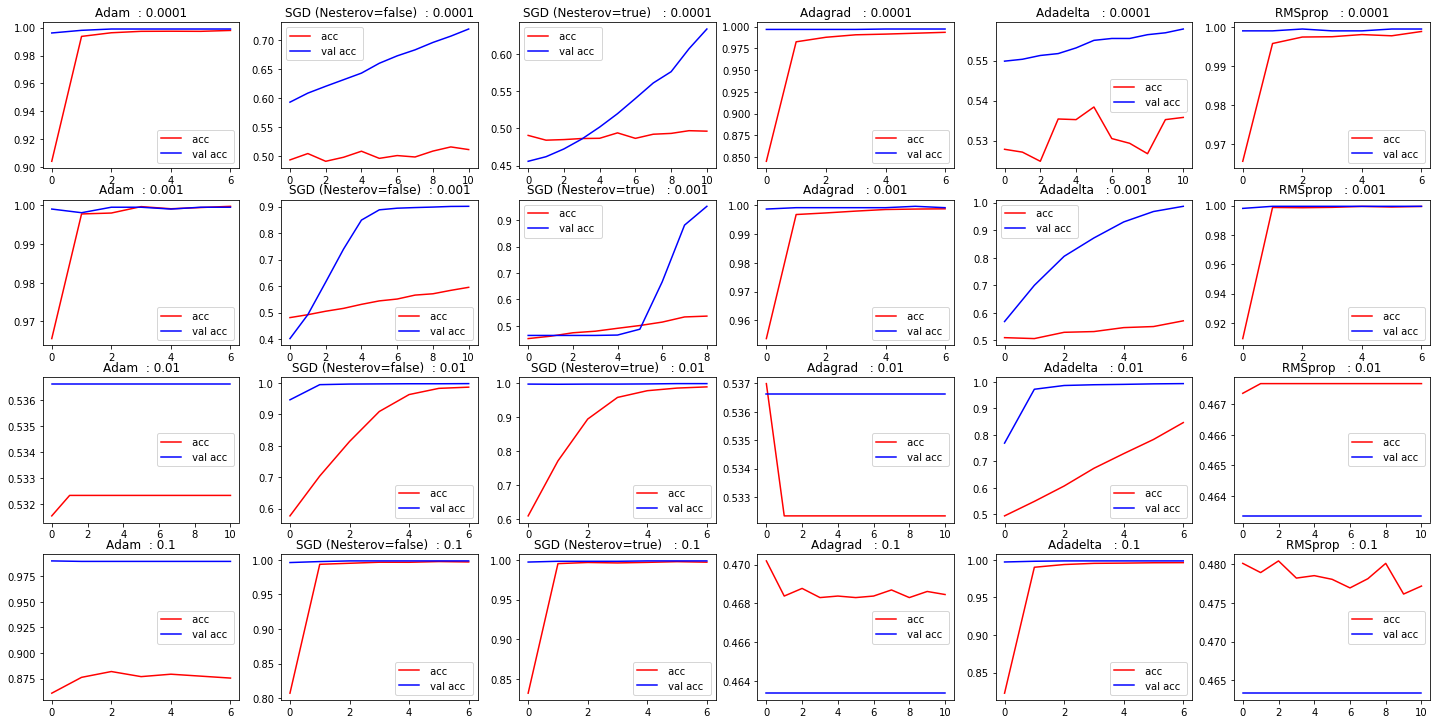

In [0]:
fig, ax = plt.subplots(figsize=(20,10),nrows=4, ncols=len(scores)//4)
plt.tight_layout() 
next = 0
for row in ax:
    for col in row:
      plot_history(scores[next][1][0], col,scores[next][0])
      next += 1